# ECS7020P advanced mini-project submission


# Introduction

In this notebook, I will create an "advanced" problem and solve it.



# 2 Problem formulation

This notebook is classification of a sounds dataset called MLEnd sound dataset. This dataset consists of 2500 samples with of on average, 8 seconds long audio data captured around different areas of London. The problem formulation for this advanced mini-project is to predict whether the given sound is taken from which area of London

# Loading and Preprocessing data

# 3 Machine Learning pipeline

Below is description of each pipeline.

I have created 4 pipelines

A. Preprocess pipeline

B. Modelling pipeline

C. Visualization pipeline

D. Prediction pipeline

### A. Preprocess pipeline:
&emsp; This pipeline takes path-to-audio files and path-to-csv file as input. The output will be preprocessed dataframe created from these files.

##### Intermediate stages:
Stage 1: Loading audio-files-path as list, and dataframe using csv.
<br>

Stage 2: Two specific audio files are corrupted so removing these files from input data
<br>

Stage 3: Data augmentation: Since the available data is only 2500 files, I will use augmentation techniques to create more data, 2500x4=10000 data. After augmentation, each audio will be loaded as mel frequency cepstrum coefficients (mfcc). Now these mfcc's will be averaged and made into an array.
<br>

Stage 4: Transform the mfcc array into appriopriate shape. Merge class labels with the array and output the extracted data. The data output shape should be 2498x4=9992 rows and 2 columns. Make note that the first column has a 20 dimensional array of mfcc of the audio data.
<br>

In [1]:
def preprocess(label_csv, audio_fpath):

  df = pd.read_csv(label_csv)
  df = df.drop(df[df.file_id == '2206.wav'].index)
  df = df.drop(df[df.file_id == '0033.wav'].index)
  df = df.rename(columns={"file_id": "filename"})
  df = df.rename(columns={"area": "category"})
    
  # adding noise to input data
  def add_noise(data):
    noise = np.random.randn(len(data))
    data_noise = data + 0.005 * noise
    return data_noise
    
  # shifting input data
  def shift(data):
    return np.roll(data, 22050)
    
  # stretching input data
  def stretch(data, rate=1):
    input_length = 220500
    data = librosa.effects.time_stretch(data, rate)
    return data
  
  extracted_data = []
  for index, row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_fpath),str(row["filename"]))
    class_labels = row['category']
    y, sr = librosa.load(file_name, sr=44100)
    for i in range(4):
      if i == 1:
        data = add_noise(y)
      if i == 2 :
        data = shift(y)
      if i == 3 :
        data = stretch(y, rate=1.25)
      else:
        data = y
      feature = librosa.feature.mfcc(y=data, sr=sr)
      scaled_feature = np.mean(feature.T,axis=0)
      extracted_data.append([scaled_feature, class_labels])
      
  return extracted_data

### B. Modelling pipeline:
&emsp; In this pipeline, I am going to create a basic Deep neural network model. The input used is from the preprocessed pipeline. The output will be model, model-history and its weights.


In [2]:
def model(extracted_data):

  feature_df = pd.DataFrame(extracted_data, columns=['feature','class'])
  x = np.array(feature_df['feature'].tolist())
  target = np.array(feature_df['class'].tolist())
  target = pd.get_dummies(target)


  X_train, X_val, y_train, y_val = train_test_split(x, 
                                                    target, 
                                                    test_size=0.3,
                                                    random_state=9)
  X_val, X_test, y_val, y_test = train_test_split(X_val, 
                                                    y_val, 
                                                    test_size=0.3,
                                                    random_state=1)
  

  print(X_train.shape, X_val.shape, X_test.shape)

  inp = (1, 20)

  new_model = Sequential()
  new_model.add(Input(shape = (1,20)))
  new_model.add(Flatten())
  new_model.add(BatchNormalization())
  new_model.add(Dense(1024,  activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(512,  activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(256, activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(64, activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(32,  activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(6, activation='softmax'))
  adam = Adam(learning_rate=0.002)

  new_model.compile(loss = 'categorical_crossentropy',
                  optimizer='adam',
                  metrics=['AUC'])

  es = EarlyStopping(
    monitor='val_auc', 
    restore_best_weights=True, 
    patience=30, min_delta = 0.001
  )

  lrr = ReduceLROnPlateau(monitor='auc', 
                        patience=3, 
                        verbose=1, 
                        factor=0.5,
                        min_lr=0.00001)

  history=new_model.fit(np.array(X_train).reshape(6994, 1, 20),
        np.array(y_train),
        epochs=500,
        callbacks = [es],
        shuffle = True,
        batch_size = 1000,
        validation_data = (np.array(X_val).reshape(2098,1,20),
                            np.array(y_val))
                           )

  return(history, new_model, y_train, y_val, X_test, y_test)


### C. Visualization pipeline
&emsp; In this pipeline, I will plot the performance of the model. The inputs will be model-history from the previous pipeline


In [3]:
def visualize(history):
  fig, (ax2,  ax3) = plt.subplots(2,1, figsize=(12,10))
  ax3.plot(history.history['auc'], color='orange')
  ax3.plot(history.history['val_auc'], color='blue')
  ax3.legend(['Val_auc','Train_auc'], loc='upper right')
  ax3.set_xlabel("Epochs")
  ax3.set_ylabel("AUC")
  ax2.plot(history.history['loss'], color='orange')
  ax2.plot(history.history['val_loss'], color='blue')
  ax2.legend(['Val_loss','Train_loss'], loc='upper right')
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Loss")
  plt.show()
  y_pred=new_model.predict(np.array(X_test).reshape(900, 1, 20))
  y_pred_classes = np.argmax(y_pred, axis=1)
  y_true = np.argmax(np.array(y_test), axis=1)

  array = confusion_matrix(y_pred_classes, y_true)
  df_cm = pd.DataFrame(array, ['British', 'Kennigston', 'Campus', 'Westend' ,'Euston', 'Southbank'], ['British', 'Kennigston', 'Campus', 'Westend' ,'Euston', 'Southbank'])
  plt.figure(figsize=(14,6))
  plt.title('Confusion Matrix for Test data')
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.show()


### D. Prediction pipeline:
&emsp; In this pipeline, I will give audio file as input, and it will predict whether the sound is from indoor or outdoor.

In [4]:
def prediction(file_path):
  y, sr = librosa.load(file_path, sr=44100)
  y = librosa.feature.mfcc(y=y, sr=sr)
  y = np.mean(y.T,axis=0)
  pred = new_model.predict(y)
  pred = np.round(pred, 0)
  df = pd.read_csv(label_csv)
  df.rename(columns={"Public filename": "file_id","Area":"area"}, inplace=True)
  area = ['Euston',	'British','Campus',	'Kensington',	'Southbank',	'Westend']
  itemindex = np.where(pred[0] == 1)
  print('The sound comes from predicted to be',area[itemindex[0][0]])
  print('The sound actually comes from',df[df['file_id']==file_path.split('/')[-1]].area.values[0])

# 4 Transformation stage

Describe any transformations, such as feature extraction. Identify input and output. Explain why you have chosen this transformation stage.

 Data augmentation: Since the available data is only 2500 files, I will use augmentation techniques to create more data, 2500x8=20000 data. After augmentation, each audio will be loaded as mel frequency cepstrum coefficients (mfcc). Now these mfcc's will be averaged and made into an array. Transform the mfcc array into appriopriate shape. Merge class labels with the array and output the extracted data. The data output shape should be 2498x8=19984 rows and 2 columns. Make note that the first column has a 20 dimensional array of mfcc of the audio data.


# 5 Modelling

Describe the ML model(s) that you will build. Explain why you have chosen them.
<br>
<br>

The ML model I will be using is a basic Deep Neural Network. I want to use this model beacause I am more interested in deep learning rather than classical machine learning. This is the reason I have augmented the data to create more data too. Also, mfcc audio data works extremely well on neural networks. 
<br>
<br>

The model is a sequential network. There are a total of 10 hidden layers. I will briefly explain below:
<br>
<br>

The first layer is input layer. Last layer is the output layer. All the layers in between are hidden layers. The first hidden layer flattens in input, next layer normalizes the batches. Now the layers are dense and dropouts layer 12 consecutive times. Each dense layer has relu as activation, except the output layer, where I have used softmax. 
<br>
<br>

Adam is the optimizer with learning rate 0.002. Loss used is categorical_crossentropy. Metrics is AUC. 
<br>
<br>

Early stopping is used if there is no improvement in validation accuracy across 30 conintuous steps. Learning rate is reduced if there is no improvement in validation accuracy for 3 steps. Minimum learning rate is set at 0.00001
<br>
<br>

The model is set to run for 500 epochs, however, it is allowed to stop early.

# 6 Methodology

Describe how you will train and validate your models, how model performance is assesssed (i.e. accuracy, confusion matrix, etc)

The performance metrics used in the model is auc. Since it is multi classification task, auc is a good enough metric.

Categorical crossentropy loss is calculated at end of each epoch. This is appropriate because the multi classification of categorical variable.

Confusion matrix is plotted in the visualization part for test result. Also, train&validation auc plots is also plotted. train&validation loss is also plotted to show there is no overfit of DNN model.

# 7 Dataset

Describe the dataset that you will use to create your models and validate them. If you need to preprocess it, do it here. Include visualisations too. You can visualise raw data samples or extracted features.

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, re, pickle, glob
import zipfile
import librosa
import seaborn as sns
from tqdm import tqdm
import IPython.display as ipd
import pandas as pd 
import librosa.display

from tensorflow.keras import regularizers
import keras
from keras.models import Sequential
#Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Dropout,Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import AUC

from sklearn.metrics import confusion_matrix

### Looking at imbalance

In [6]:
# preprocess takes alot of time so I will load the already preprocessed file
pickle_load = open('/kaggle/input/mlend-preprocessed-pickle/advanced_extracted_data.pickle','rb')
extracted_data = pickle.load(pickle_load)
pickle_load.close()

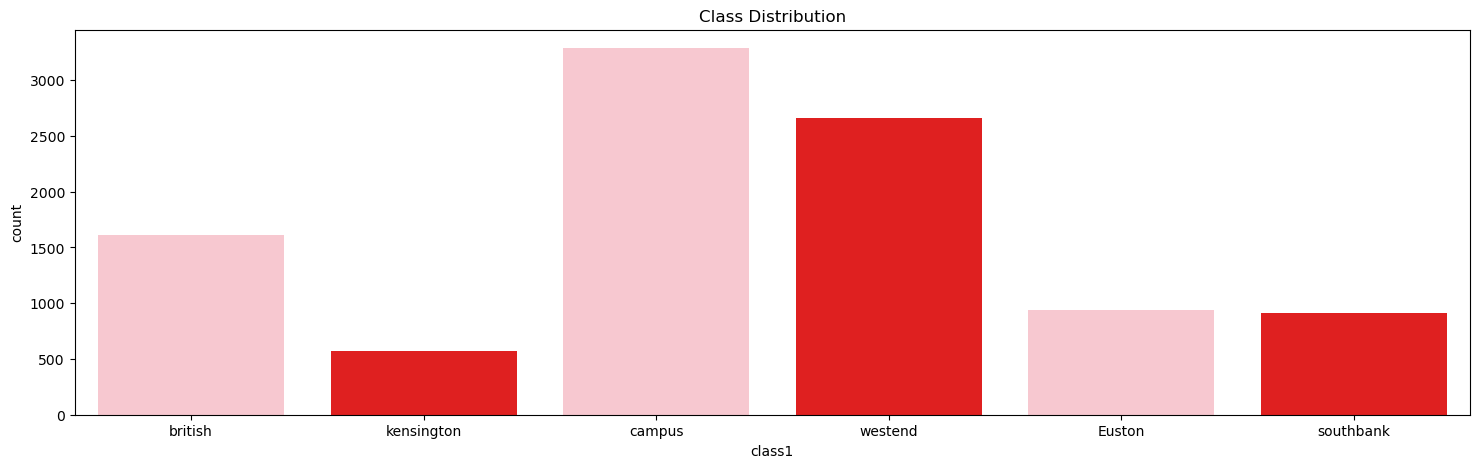

In [7]:
feature_df = pd.DataFrame(extracted_data, columns=['feature','class1'])

Class = feature_df.class1.value_counts()
colours = ["pink", "red"]
f, ax = plt.subplots(figsize=(18,5)) 
ax = sns.countplot(x='class1', data=feature_df, palette=colours)
plt.title('Class Distribution');

The imbalance seems to be very significant

## Audio Augmentation: 

Inorder to increase the number of data available to train neural network, I am augmenting the dataset. Below are the examples of each augmentation in the given dataset

Loading an audio file and plotting its wavplot

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  This is separate from the ipykernel package so we can avoid doing imports until


Class:  british
Sampling Rate:  22050 Hz
Duration:  9.59002267573696
Number of samples:  211460


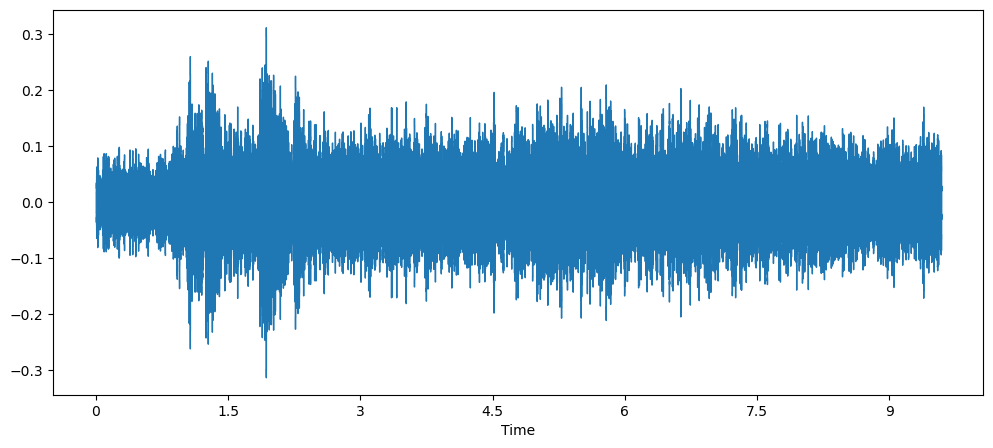

In [8]:
y, sr = librosa.load('/kaggle/input/mlend-london-sounds/wav_files/wav_files/0001.wav')
plt.figure(figsize=(12,5))
librosa.display.waveshow(y,sr);
print('Class: ', feature_df.class1[0])
print('Sampling Rate: ',sr,'Hz')
print('Duration: ',len(y)/sr)
print('Number of samples: ', len(y))
ipd.Audio(data=y, rate=sr)

### Audio noise
Adding background noise to the audio data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  after removing the cwd from sys.path.


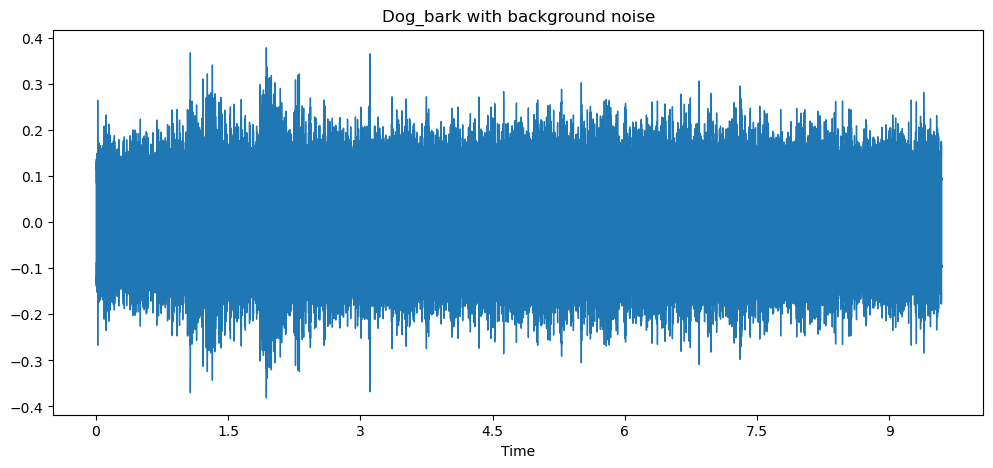

In [9]:
plt.figure(figsize=(12,5))
noise = np.random.randn(len(y))
data_noise = y + 0.05 * noise
librosa.display.waveshow(data_noise,sr);
plt.title('Dog_bark with background noise')
ipd.Audio(data=data_noise, rate=sr)

### Audio stretch
Streching the loaded audio file, or in other words slowing down the audio

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Pass rate=0.5 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  This is separate from the ipykernel package so we can avoid doing imports until


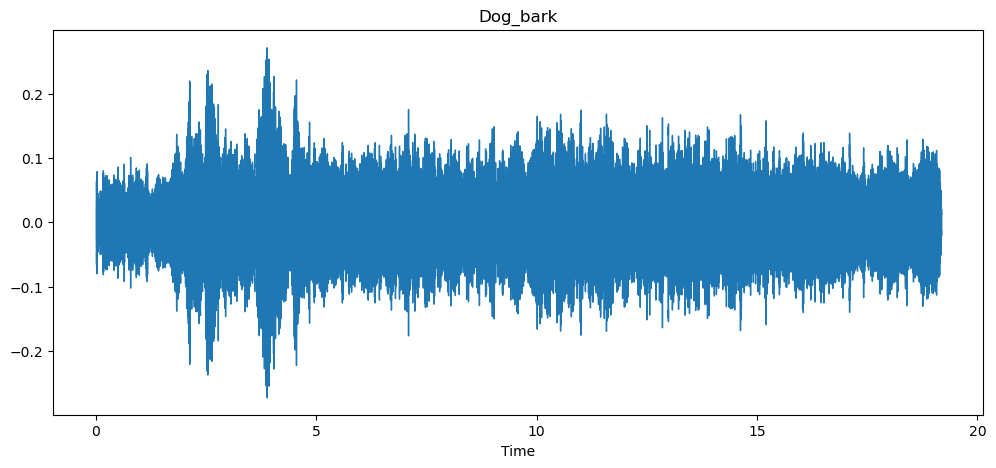

In [10]:
plt.figure(figsize=(12,5))
y_fast = librosa.effects.time_stretch(y, 0.5)
librosa.display.waveshow(y_fast,sr);
plt.title('Dog_bark')
ipd.Audio(data=y_fast, rate=sr)

### Numpy Shift
Shifting array of the audio file. The array values will get rolled onto another dimension

In [11]:
print('Before Roll')
x = np.random.random((5,5))
print(x)
x = np.roll(x,5)
print('\nAfter Roll')
print(x)

Before Roll
[[0.84583531 0.35814121 0.00800259 0.82313543 0.38907301]
 [0.56567975 0.22320291 0.381172   0.61889198 0.8986093 ]
 [0.73262835 0.45582463 0.83683992 0.33819664 0.9410162 ]
 [0.73501468 0.78924278 0.27223495 0.57863091 0.28087426]
 [0.34589531 0.229218   0.93666108 0.42269688 0.37969877]]

After Roll
[[0.34589531 0.229218   0.93666108 0.42269688 0.37969877]
 [0.84583531 0.35814121 0.00800259 0.82313543 0.38907301]
 [0.56567975 0.22320291 0.381172   0.61889198 0.8986093 ]
 [0.73262835 0.45582463 0.83683992 0.33819664 0.9410162 ]
 [0.73501468 0.78924278 0.27223495 0.57863091 0.28087426]]


## Data visualization 
In this section, I will include basic visualization of data

### Mel Spectrogram

The Mel Scale gives better resolution lower frequencies. 

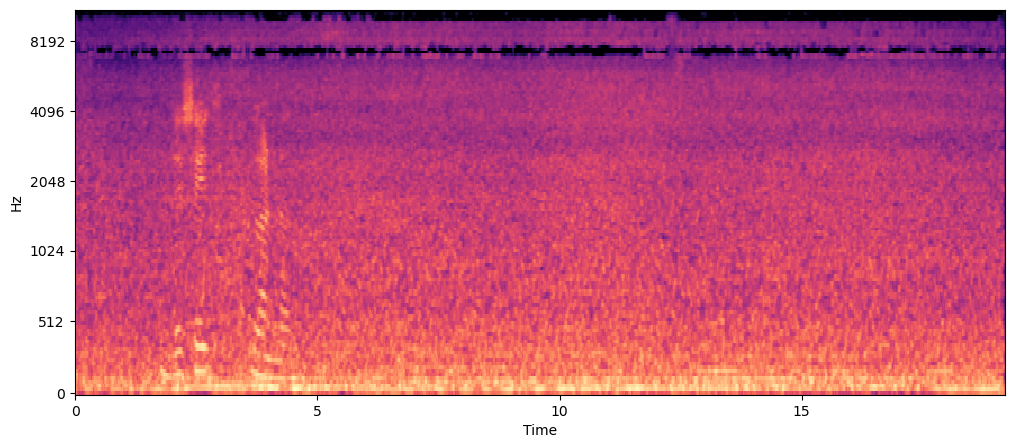

In [12]:
plt.figure(figsize=(12,5))
S = librosa.feature.melspectrogram(y=y_fast, sr=sr,n_fft=2048, hop_length=512)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel')
plt.show()

### MFCC
Mel-frequency cepstral coefficients (MFCCs)- The coefficients that form the short-term power spectrum of a sound. This is the feature extracted from the audio file, since mfcc are one of the best features for neural networks

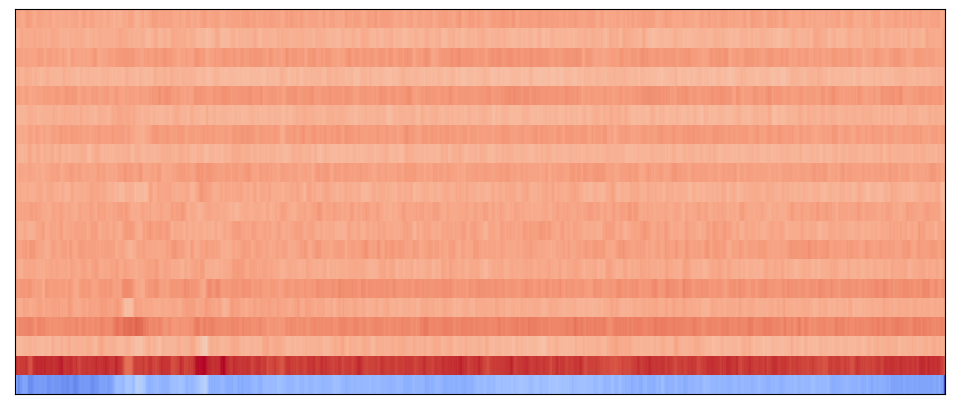

In [13]:
plt.figure(figsize=(12,5))
S = librosa.feature.mfcc(y=y_fast, sr=sr, dct_type=2)
librosa.display.specshow(S)
plt.show()

### Chroma
Chroma features are the entire spectrum which is projected onto 12 chroma of the musical octave

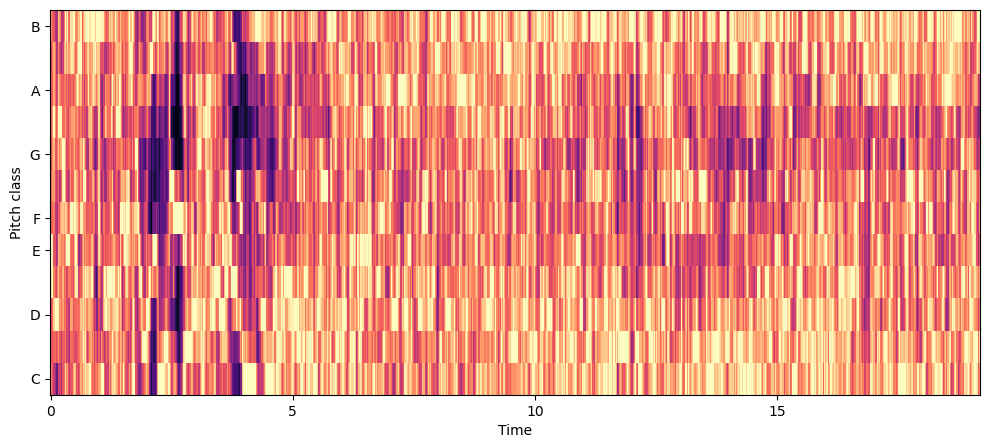

In [14]:
plt.figure(figsize=(12,5))
S = np.abs(librosa.stft(y_fast))
chroma = librosa.feature.chroma_stft(S=S, sr=sr)
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.show()

# 8 Results

Carry out your experiments here, explain your results.

Preprocessing takes too much time, hence i have already saved the output. So i will load it again to save time

In [15]:
label_csv = '/kaggle/input/mlend-london-sounds/MLEndLSD.csv'
audio_fpath = '/kaggle/input/mlend-london-sounds/wav_files/wav_files'

#extracted_data = preprocess(label_csv, audio_fpath)

#pick_insert = open('drive/My Drive/Data/MLEndLS/advanced_extracted_data.pickle','wb')
#with open("drive/My Drive/Data/MLEndLS/advanced_extracted_data.pickle", "wb") as pickle_file:
#     pickle.dump(extracted_data, pickle_file)

In [16]:
pickle_load = open('/kaggle/input/mlend-preprocessed-pickle/advanced_extracted_data.pickle','rb')
extracted_data = pickle.load(pickle_load)
pickle_load.close()

In [17]:
history, new_model, y_train, y_val, X_test, y_test = model(extracted_data)

(6994, 20) (2098, 20) (900, 20)
Epoch 1/500
7/7 [==============================] - 2s 135ms/step - loss: 1.7803 - auc: 0.5843 - val_loss: 2.0864 - val_auc: 0.6806
Epoch 2/500
7/7 [==============================] - 0s 69ms/step - loss: 1.7133 - auc: 0.6486 - val_loss: 1.6180 - val_auc: 0.7042
Epoch 3/500
7/7 [==============================] - 0s 70ms/step - loss: 1.6834 - auc: 0.6675 - val_loss: 1.5973 - val_auc: 0.7163
Epoch 4/500
7/7 [==============================] - 1s 76ms/step - loss: 1.6658 - auc: 0.6776 - val_loss: 1.5900 - val_auc: 0.7230
Epoch 5/500
7/7 [==============================] - 0s 69ms/step - loss: 1.6477 - auc: 0.6898 - val_loss: 1.5919 - val_auc: 0.7335
Epoch 6/500
7/7 [==============================] - 0s 68ms/step - loss: 1.6341 - auc: 0.6946 - val_loss: 1.6022 - val_auc: 0.7407
Epoch 7/500
7/7 [==============================] - 0s 71ms/step - loss: 1.6141 - auc: 0.7049 - val_loss: 1.5844 - val_auc: 0.7419
Epoch 8/500
7/7 [==============================] - 1s 74m

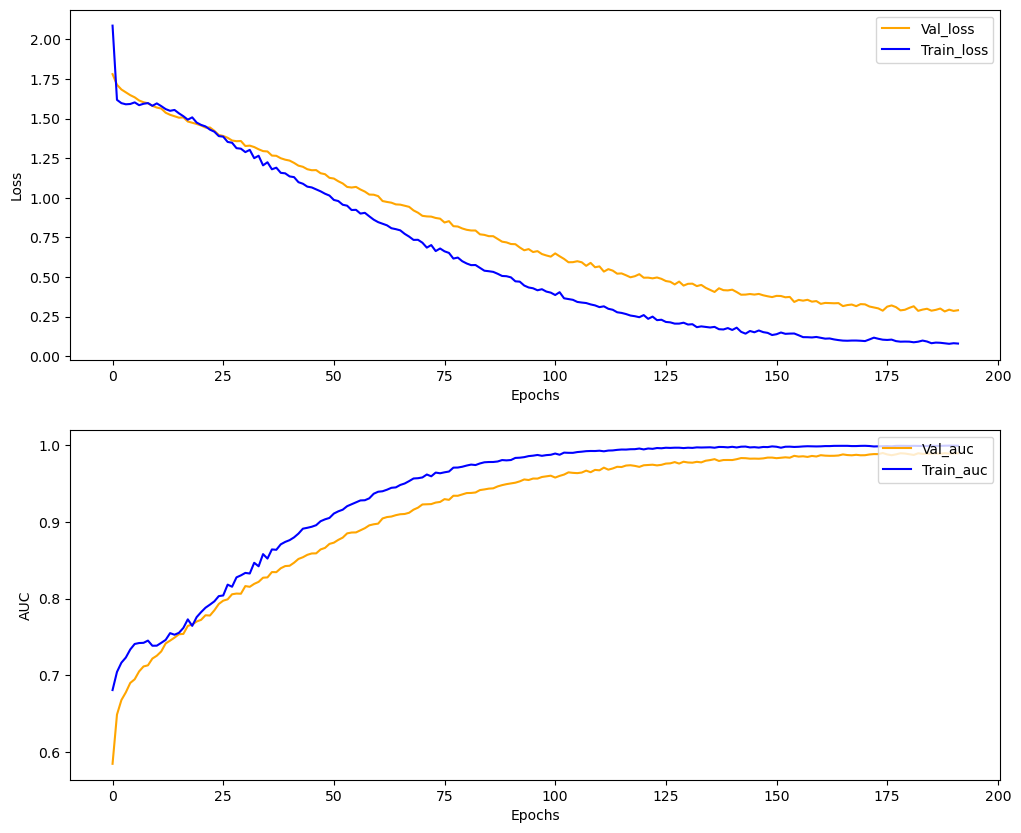

29/29 [==============================] - 0s 3ms/step


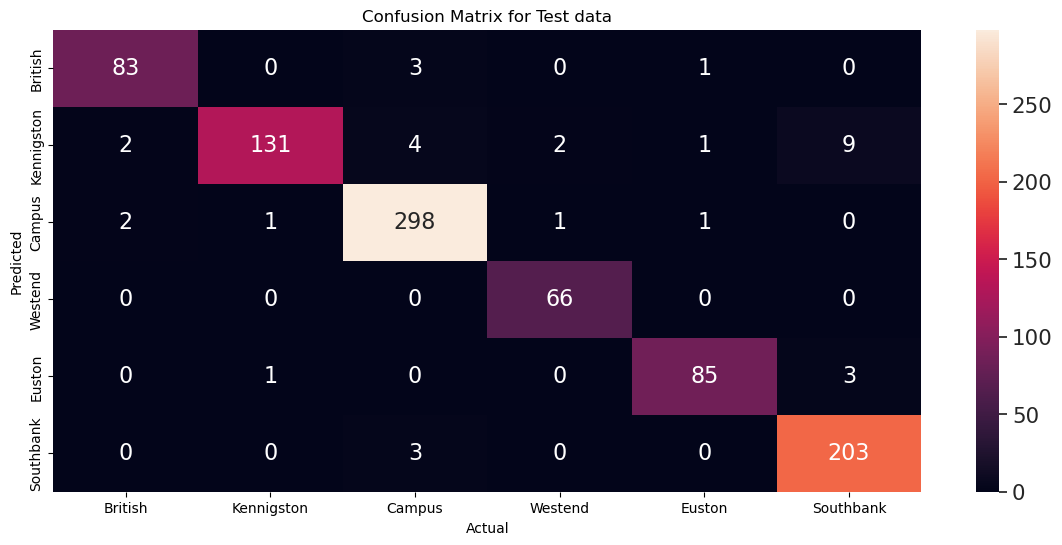

In [18]:
visualize(history)

## You can check for model performance here

You can change the file_id value as you wish. No need to worry about bias through test files because validation auc is 0.99. 

In [19]:
id = "0001"
prediction('/kaggle/input/mlend-london-sounds/wav_files/wav_files/'+id+'.wav')

1/1 [==============================] - 0s 130ms/step
The sound comes from predicted to be British
The sound actually comes from british


# 9 Conclusions

The neural network works amazingly well on the dataset using mfcc features. There is no scope of improvement, and thats why there is only 1 model pipeline